In [18]:
from datasets import load_dataset
import openai
import matplotlib.pyplot as plt
import numpy as np

from llama_index.core import StorageContext, Document, Settings, KnowledgeGraphIndex
from llama_index.core.graph_stores import SimpleGraphStore
from llama_index.llms.openai import OpenAI
from llama_index.core import StorageContext
from llama_index.core import VectorStoreIndex
from llama_index.vector_stores.chroma import ChromaVectorStore
from query_engine import RAGStringQueryEngine, RAGCachedStringQueryEngine

from tqdm import tqdm

from llama_index.core.graph_stores import SimpleGraphStore

from tqdm import trange

from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import pandas as pd

In [ ]:
import os
openai.api_key = os.environ['OPENAI_API_KEY']

In [3]:
coqa_dataset = load_dataset("stanfordnlp/coqa")

In [4]:
questions = [list(row) for row in coqa_dataset["train"].to_pandas()['questions'][:2000]]

In [5]:
answers = [list(row["input_text"]) for row in coqa_dataset["train"].to_pandas()["answers"][:2000]]

In [6]:
documents = [Document(text=row) for row in coqa_dataset["train"].to_pandas()["story"][:2000]]

In [7]:
llm = OpenAI(temperature=0, model="gpt-3.5-turbo-instruct")
Settings.llm = llm
Settings.chunk_size = 512

In [8]:
import chromadb

chroma_client = chromadb.PersistentClient()
chroma_collection = chroma_client.get_or_create_collection("quickstart")

In [9]:
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

In [10]:
#documents = [Document(text=doc) for doc in coqa_dataset["train"].to_pandas()['story']]
#index = VectorStoreIndex(documents, storage_context=storage_context)

# If you have already run the notebook, then comment previous lines and run the following line
index = VectorStoreIndex.from_vector_store(vector_store)

In [11]:
query_engine = index.as_query_engine(
    similarity_top_k=5
)

In [13]:

answers_dict_no_graph = {}

for i in tqdm(range(100)):
    for j in range(len(questions[i])):
        #print("QUESTION: ", questions[i][j])
        response = str(query_engine.query(questions[i][j]))
        #print("RESPONSE: " + response)
        #print("ANSWER: " + answers[i][j] + "\n")
        answers_dict_no_graph[answers[i][j]] = response


  2%|▏         | 2/100 [00:19<15:57,  9.77s/it]


KeyboardInterrupt: 

In [14]:

answers_dict_graph = {}
no_cache_profile = []
cache_profile = []

for i in tqdm(range(100)):
    #print("BUILDING KNOWLEDGE GRAPH")
    temp_graph_store = SimpleGraphStore()
    temp_graph_storage_context = StorageContext.from_defaults(graph_store=temp_graph_store)
    temp_kg_index = KnowledgeGraphIndex.from_documents(
        [documents[i]],
        max_triplets_per_chunk=100,
        storage_context=temp_graph_storage_context,
        show_progress=True,
        include_embeddings=True,
    )

    engine = RAGStringQueryEngine(llm, temp_kg_index, index, 3, 5, 5)
    cache_engine = RAGCachedStringQueryEngine(llm, temp_kg_index, index, 3, 5, 5)
    for j in trange(len(questions[i])):
        #print("QUESTION: ", questions[i][j])
        response = str(engine.custom_query(questions[i][j]))
        #print("RESPONSE: " + response)
        cache_engine.custom_query(questions[i][j])
        #print("ANSWER: " + answers[i][j] + "\n")
        answers_dict_graph[answers[i][j]] = response
    no_cache_profile.extend(engine.time_profile)
    cache_profile.extend(cache_engine.time_profile)
        

  0%|          | 0/100 [00:00<?, ?it/s]

Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/334 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 20/20 [01:48<00:00,  5.40s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/23 [00:00<?, ?it/s]

Cache size set to:  0



100%|█████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/45 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 20/20 [01:34<00:00,  4.75s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/27 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 20/20 [01:49<00:00,  5.49s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/32 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 10/10 [00:38<00:00,  3.89s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/30 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 20/20 [01:37<00:00,  4.88s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/228 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 21/21 [01:37<00:00,  4.66s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/17 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.65s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/25 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 10/10 [00:47<00:00,  4.75s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/25 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 11/11 [00:58<00:00,  5.31s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/27 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 16/16 [01:36<00:00,  6.05s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/22 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 19/19 [01:15<00:00,  3.97s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/15 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 12/12 [00:52<00:00,  4.37s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/40 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 19/19 [01:51<00:00,  5.88s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/33 [00:00<?, ?it/s]

Cache size set to:  0



100%|█████████████████████████████████████████████| 4/4 [00:22<00:00,  5.74s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/48 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 20/20 [01:35<00:00,  4.79s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/38 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 13/13 [01:02<00:00,  4.80s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/12 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 20/20 [01:22<00:00,  4.12s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/13 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 10/10 [00:36<00:00,  3.66s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/26 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 19/19 [01:27<00:00,  4.61s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/20 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 18/18 [01:28<00:00,  4.90s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/23 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 18/18 [01:20<00:00,  4.49s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/253 [00:00<?, ?it/s]

Cache size set to:  0



100%|███████████████████████████████████████████| 20/20 [01:39<00:00,  4.95s/it]


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

APITimeoutError: Request timed out.

In [15]:

embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5"
)

In [16]:
def get_cos_similarities(ans, graph_res, no_graph_res):
    ans_embed = np.array(embed_model.get_text_embedding(ans))
    graph_embed = np.array(embed_model.get_text_embedding(graph_res))
    no_graph_embed = np.array(embed_model.get_text_embedding(no_graph_res))

    graph_cos_sim = np.dot(ans_embed, graph_embed) / (np.linalg.norm(ans_embed) * np.linalg.norm(graph_embed))
    no_graph_cos_sim = np.dot(ans_embed, no_graph_embed) / (np.linalg.norm(ans_embed) * np.linalg.norm(no_graph_embed))
    return graph_cos_sim, no_graph_cos_sim


In [17]:
graph_cos_sims = []
no_graph_cos_sims = []

for i in range(100):
    for j in range(len(questions[i])):
        try:
            graph_cos_sim, no_graph_cos_sim = get_cos_similarities(answers[i][j], answers_dict_graph[answers[i][j]], answers_dict_no_graph[answers[i][j]])
            graph_cos_sims.append(graph_cos_sim)
            no_graph_cos_sims.append(no_graph_cos_sim)
        except:
            continue

print("AVG COS SIM WITH NO GRAPH: ", np.mean(no_graph_cos_sims))
print("AVG COS SIM WITH GRAPH: ", np.mean(graph_cos_sims))

AVG COS SIM WITH NO GRAPH:  0.539081288042208
AVG COS SIM WITH GRAPH:  0.6029144061196389


In [18]:
graph_em = []
no_graph_em = []

for i in range(100):
    for j in range(len(questions[i])):
        try:
            if answers_dict_graph[answers[i][j]].find(answers[i][j]) != -1:
                graph_em.append(1.0)
            else:
                graph_em.append(0.0)
    
            if answers_dict_no_graph[answers[i][j]].find(answers[i][j]) != -1:
                no_graph_em.append(1.0)
            else:
                no_graph_em.append(0.0)
        except:
            continue

print("AVG EM WITH NO GRAPH: ", np.mean(no_graph_em))
print("AVG EM WITH GRAPH: ", np.mean(graph_em))

AVG EM WITH NO GRAPH:  0.24217462932454695
AVG EM WITH GRAPH:  0.44481054365733114


In [19]:
no_cache_latency_keys = ['DOCUMENT RETRIEVAL', 'NODE RETRIEVAL', 'NODE TRAVERSAL']
cache_latency_keys = ['NODE RETRIEVAL', 'NODE TRAVERSAL', 'DOCUMENT RETRIEVAL', 'READ FROM CACHE', 'CACHE RETRIEVAL', 'WRITE TO CACHE']
total_latency_no_cache = [sum([node[key] for key in no_cache_latency_keys]) for node in no_cache_profile]
total_latency_with_cache = [sum([node[key] for key in cache_latency_keys]) for node in cache_profile]
total_retrieved_no_cache = [node["NUM TOTAL DOCUMENTS"] for node in no_cache_profile]
total_retrieved_cache = [node["NUM TOTAL DOCUMENTS"] for node in cache_profile]

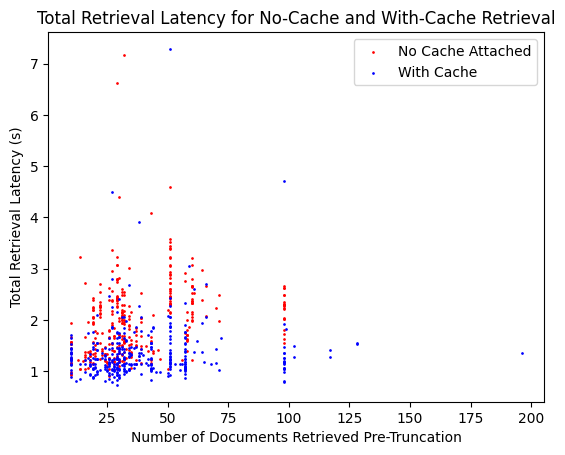

In [20]:
plt.scatter(total_retrieved_no_cache, total_latency_no_cache, c='r', s=0.9, label="No Cache Attached")
plt.scatter(total_retrieved_cache, total_latency_with_cache, c='b', s=0.9, label="With Cache")
plt.title("Total Retrieval Latency for No-Cache and With-Cache Retrieval")
plt.xlabel("Number of Documents Retrieved Pre-Truncation")
plt.ylabel("Total Retrieval Latency (s)")
plt.legend()
plt.show()

In [21]:
avg_latency_no_cache = {key: sum([node[key] for node in no_cache_profile]) / len(total_retrieved_cache) for key in no_cache_latency_keys}
avg_latency_cache = {key: sum([node[key] for node in cache_profile]) / len(total_retrieved_cache) for key in cache_latency_keys}

In [22]:
avg_latency_no_cache['READ FROM CACHE'] = 0.0
avg_latency_no_cache['CACHE RETRIEVAL'] = 0.0
avg_latency_no_cache['WRITE TO CACHE'] = 0.0

In [23]:
import pandas as pd

df = pd.DataFrame([['No Cache Attached', avg_latency_no_cache['NODE RETRIEVAL'], avg_latency_no_cache['NODE TRAVERSAL'], avg_latency_no_cache['DOCUMENT RETRIEVAL'], 
                    0.0, 0.0, 0.0], 
                   ['With Cache', avg_latency_cache['NODE RETRIEVAL'], avg_latency_cache['NODE TRAVERSAL'], avg_latency_cache['DOCUMENT RETRIEVAL'], 
                    avg_latency_cache['READ FROM CACHE'], avg_latency_cache['CACHE RETRIEVAL'], avg_latency_cache['WRITE TO CACHE']]],
                  columns=['Cache State', 'NODE RETRIEVAL', 'NODE TRAVERSAL', 'DOCUMENT RETRIEVAL', 'READ FROM CACHE', 'CACHE RETRIEVAL', 'WRITE TO CACHE'])

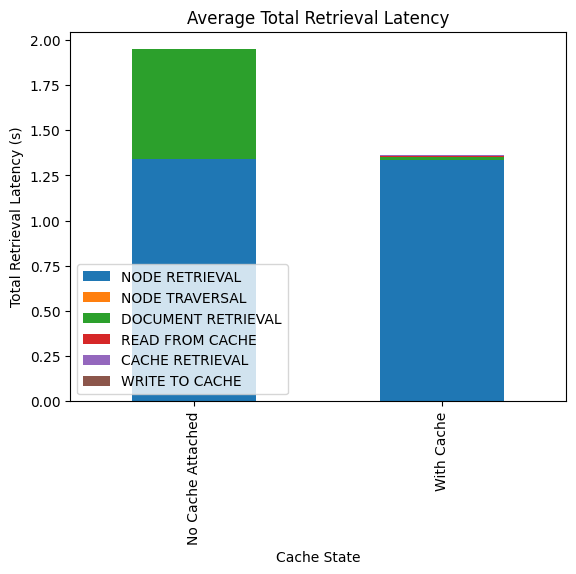

In [24]:
df.plot(x='Cache State', kind='bar', stacked=True,
        title='Average Total Retrieval Latency')
plt.ylabel("Total Retrieval Latency (s)")
plt.show()